# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             classification_report, confusion_matrix,
                             roc_curve, auc,
                             average_precision_score, precision_recall_curve)
from ml.visualization import plot_confusion_matrix

%matplotlib inline

np.random.seed(0)  # Para mayor determinismo

---
## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
display(dataset.head())

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


---
## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [3]:
# Se guardan el 20% de los datos para test
# NOTA: train_test_split por defecto realiza el shuffle de los datos antes del splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
display(X_train.describe())

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000
mean,19019.487525,76396.345920,107329.562374,8.948753,0.186109,0.326365,179.558267,1.140931,21.859069,34.538331
std,10755.943240,45995.563918,55261.111710,7.577317,0.696353,0.925001,85.433422,1.683761,9.452400,9.566838
min,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,12050.000000,48717.500000,71156.000000,3.000000,0.000000,0.000000,116.439339,0.000000,16.000000,29.293916
50%,17000.000000,67389.000000,94504.000000,7.000000,0.000000,0.000000,174.506408,1.000000,21.000000,35.302774
75%,23700.000000,94648.500000,124155.500000,13.000000,0.000000,0.000000,233.763633,2.000000,27.000000,39.200625
max,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,11.000000,65.000000,144.189001


---
## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:

### 2.1. Selección de hipótesis

Nos vamos a basar en una hipotesis lineal.

### 2.2. Selección de regularizador

L2 Regularizor: $\lambda * \sum_{i=1}^{k}W_i^2 $

### 2.3. Selección de función de coste

Squared lost: $V(f({\vec  {x}}),y)=(1-yf({\vec  {x}}))^{2}$

### 2.4. Justificación de las selecciones

Notar que se trata de resolver un problema de clasificación binaria. Asumiendo que los datos son linealmente separables se posibilita la utilización de una hipótesis lineal. Decidimos usar SGDClassifier ya que este se basa en modelos lineales y además utiliza la optimización de descenso estocástico por gradiente.

En cuanto a la elección de la función de coste se va a utilizar 'squared loss'. Suponemos que la ocurrencia de outliers, por la naturaleza del problema, va a ser baja. Caso contrario se deberia optar por otra función de coste que no penalice fuertemente a los valores atípicos.

Finalmente, en base a la función de costo elegida, es que se decide utilizar 'L2 Regularizor' como regularizador para que penalice los valores grandes de los coeficientes (pesos Wj's).

---
## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

In [5]:
cv = 5                # 5-fold cross-validation
scoring = 'roc_auc'   # metrica: area bajo la curva ROC
loss = 'squared_loss' # Funcion de Coste
penalty = 'l2'        # Regularizador

exploring_params = {
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.1, 0.01, 0.001, 0.0001, 0.5, 0.05, 0.005],  # Tasa de entrenamiento
    'alpha': [0.1, 0.01, 0.001, 0.0001, 0.5, 0.05, 0.005], # Tasa de regularización
    'tol': [0, 1e-3]
}

m = SGDClassifier(loss=loss, penalty=penalty, max_iter=20000)
model = GridSearchCV(m, exploring_params, cv=cv, scoring=scoring)
y_score = model.fit(X_train, y_train).decision_function(X_test)

print("\tPuntajes de la grilla:")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
   print("\t\tROC_AUC: %0.3f (+/- %0.03f) para los parámetros %r" % (mean, std ** 2, params))

print("\tMejor conjunto de parámetros:")
print("\t\t{}".format(model.best_params_))

	Puntajes de la grilla:
		ROC_AUC: 0.445 (+/- 0.001) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'tol': 0}
		ROC_AUC: 0.553 (+/- 0.002) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'tol': 0.001}
		ROC_AUC: 0.442 (+/- 0.001) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'tol': 0}
		ROC_AUC: 0.466 (+/- 0.004) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'tol': 0.001}
		ROC_AUC: 0.464 (+/- 0.001) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'invscaling', 'tol': 0}
		ROC_AUC: 0.491 (+/- 0.005) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'invscaling', 'tol': 0.001}
		ROC_AUC: 0.520 (+/- 0.005) para los parámetros {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant', 'tol': 0}
		ROC_AUC: 0.498 (+/- 0.002) para los parámetros {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant', 'tol': 0.001}
		ROC_AUC: 0.546 (+/- 0.002)

---
## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

In [6]:
# Se realiza la prediccion sobre el conjunto de test
y_true, y_pred = y_test, model.predict(X_test)

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):",
      end="\n\n")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
print("\nMetricas:")
print("----------------")
print("\t* Accuracy  = {:.2f}".format(acc))
print("\t* F1        = {:.2f}".format(f1))
print("\t* Precision = {:.2f}".format(prec))
print("\t* Recall    = {:.2f}".format(rec))

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

             precision    recall  f1-score   support

          0       1.00      0.00      0.01       313
          1       0.16      1.00      0.27        58

avg / total       0.87      0.16      0.05       371


Metricas:
----------------
	* Accuracy  = 0.16
	* F1        = 0.27
	* Precision = 0.16
	* Recall    = 1.00


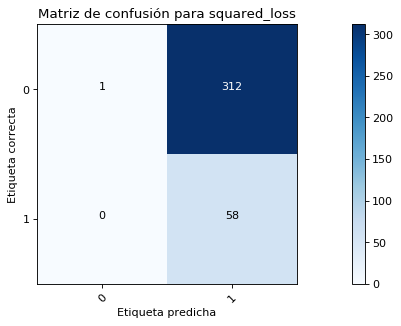

In [7]:
# Confusion Matrix
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=[0, 1], title="Matriz de confusión para %s" % loss)

---
## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

### 5.1. ROC Curve

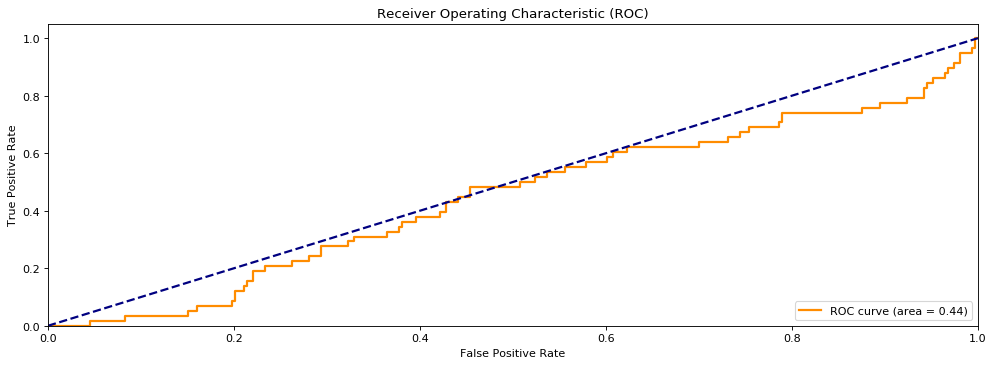

In [8]:
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### 5.2. Precision-Recall Curve

Average precision-recall score: 0.14


Text(0.5,1,'2-class Precision-Recall curve: AP=0.14')

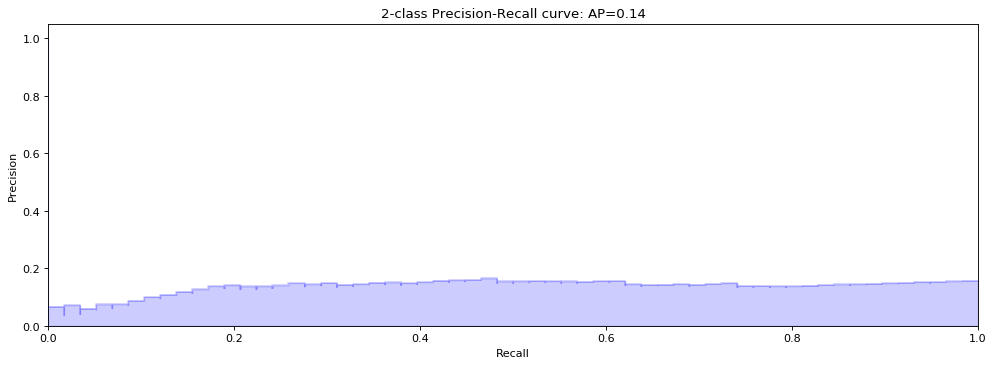

In [9]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))